# Week 13 - Gaussian processes

Hello again. Welcome to week 13! In this week, you will learn about Gaussian processes.

The usual imports...

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Part 1: Sampling from a GP with different covariance functions

A Gaussian process (GP) is defined as a collection of random variables, any finite number of which have (consistent) joint Gaussian distributions. 

A GP is a stochastic process fully specified by a mean function $m(\textbf{x}) = \mathbb{E}[f(\textbf{x})]$ and a positive definite covariance function $k(\textbf{x},\textbf{x}') = \mbox{cov}[f(\textbf{x}),f(\textbf{x}')]$. 

By making use of the mean and covariance functions, GPs specify a way to determine the mean of any arbitrary point $\textbf{x}$ in the input space and how that point covaries with the other points $\textbf{x}'$. 

The mean function of a GP is, without loss of generality, typically assumed to be zero, as the closer x and x' are, the exponential below would go towards 0.

A key step in modelling data with Gaussian processes is then to specify the covariance function $k(\textbf{x},\textbf{x}')$. Perhaps the most popular choice is the squared exponential covariance function, defined as:

\begin{align}
k_{\mbox{SE}}(\textbf{x},\textbf{x}') = \exp \Big( - l \, \sum_{d=1}^D (x_d - x'_d)^2 \Big) 
\end{align}

Note that this is slightly different from the one in the slides, but it is equivalent! This specification is more convinient to implement and manipulate.

Lets implement it in Python/Numpy:

In [3]:
def covSE(x1, x2, cov_params):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

As we discussed in the slides, if we loosely see a function $f(\textbf{x})$ as a infinitely long vector $\textbf{f} = (f(\textbf{x}_1),\dotsc,f(\textbf{x}_N))^T$, then we can think of a GP as a probability distribution over functions!

Having specified a GP prior for the function values $\textbf{f}$, $\textbf{f} \sim \mathcal{GP}(m(\textbf{x}), k(\textbf{x},\textbf{x}'))$, the next step is to construct the covariance matrix $\textbf{K}$, where $\textbf{K}_{ij} = k(\textbf{x}_i,\textbf{x}_j))$.

Lets create a function for that:

In [4]:
def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

The GP specifies a multivariate Gaussian distribution on $\textbf{f}$:

\begin{align}
\textbf{f} \sim \mathcal{N}(\textbf{f}\, |\, \textbf{0}, \textbf{K})
\end{align}

This is our prior distribution over $\textbf{f}$. We can therefore use it to sample from the GP prior!

Make sure that you understand the following code:

In [5]:
def sample_GP_prior(N_samples, cov_func, cov_params):
    # specify inputs
    X = np.arange(-4.0,4.0,0.05)[:,np.newaxis]

    # construct K (covariance matrix for every possible combination of X's elements)
    K = cov(X, X, cov_func, cov_params)

    # take N samples from the prior multivariate Gaussian: Normal(0, K)
    y = np.random.multivariate_normal(np.zeros(len(K)), K, N_samples)

    # plot samples
    for i in range(len(y)):
        plt.plot(X, y[i])
    plt.title("%d random functions sampled from the Gaussian process prior" % (len(y),))
    plt.show()

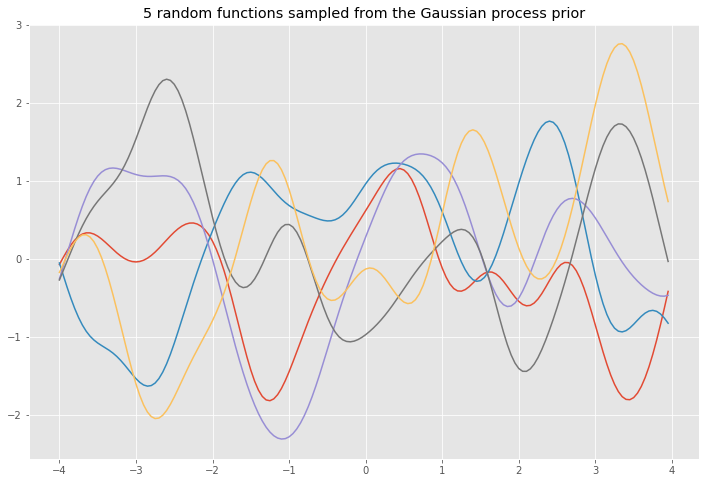

In [6]:
sample_GP_prior(5, covSE, [2.0])

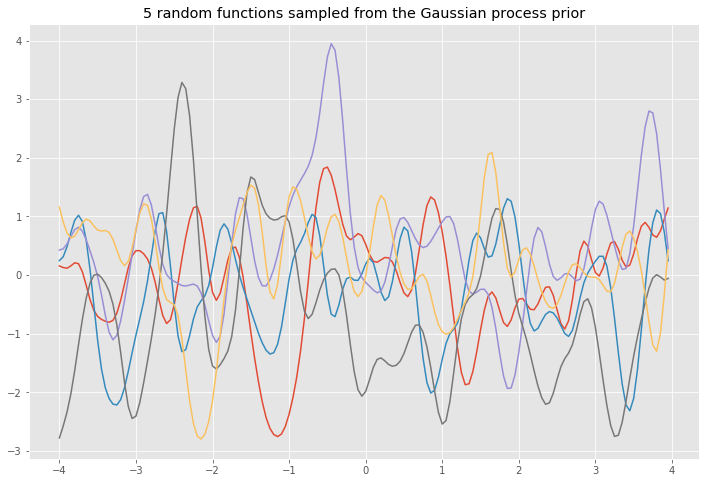

In [9]:
sample_GP_prior(5, covSE, [17.0])

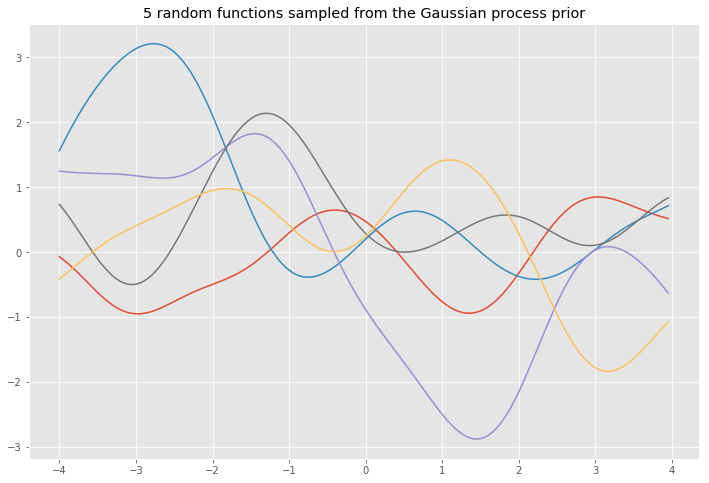

In [10]:
sample_GP_prior(5, covSE, [0.5])

Notice how a GP prior with a Squared Exponential covariance function prefers smooth functions. Try playing with the length-scale parameter of the Squared Exponential covariance function to see how that affects the sampled function from the GP prior. 

Another popular covariance function, especially for time-series data, is the Periodic covariance function:

\begin{align}
k_{\mbox{PER}}(\textbf{x},\textbf{x}') = h \, \exp \Bigg( - l \, \sin^2 \bigg( \frac{\pi}{p} \sum_{d=1}^D x_d - x'_d \bigg) \Bigg) 
\end{align}

Lets implement it in Python and sample some functions from a GP prior with a Periodic covariance function:

In [11]:
def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))
    #       magnitude               length                                       period

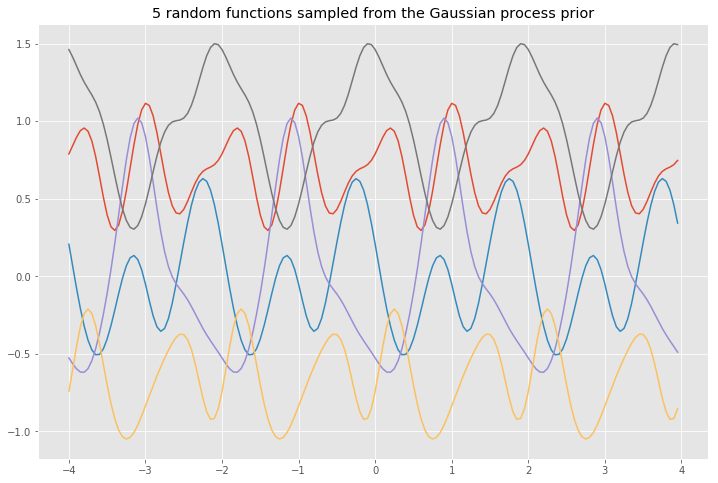

In [12]:
sample_GP_prior(5, covPER, [1.0, 1.0, 2.0])

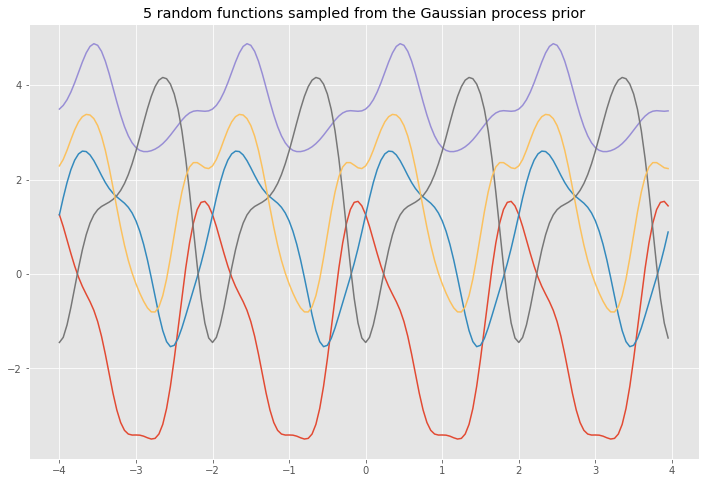

In [13]:
sample_GP_prior(5, covPER, [10.0, 1.0, 2.0])

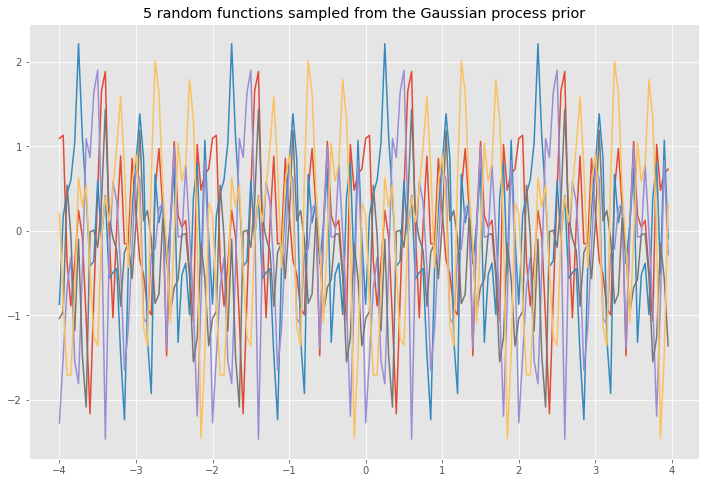

In [14]:
sample_GP_prior(5, covPER, [1.0, 100.0, 2.0])

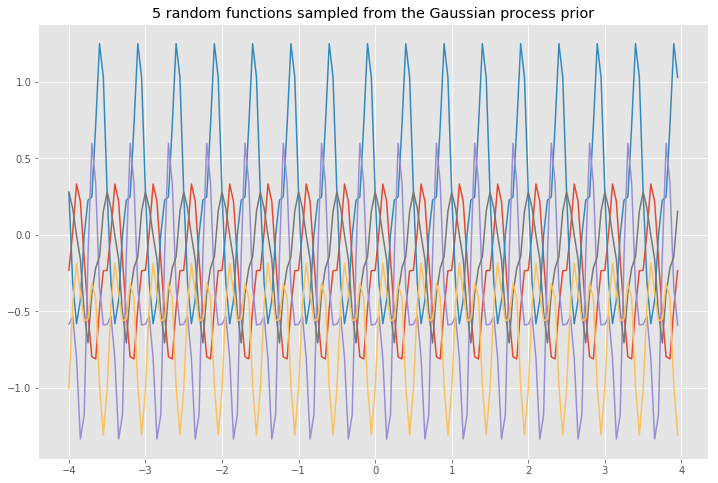

In [15]:
sample_GP_prior(5, covPER, [1.0, 1.0, 0.5])

Don't forget to play with the parameters of the covariance function to see how they affect the samples!

Another popular covariance function is the White Noise covariance function:

\begin{align}
k_{\mbox{WN}}(\textbf{x},\textbf{x}') = \sigma^2 \, \delta(\textbf{x},\textbf{x}')
\end{align}

Lets implement it in Python and sample some functions from a GP prior with a White Noise covariance function:

In [16]:
def covWN(x1, x2, cov_params):
    if x1 == x2:
        return cov_params[0]
    else:
        return 0

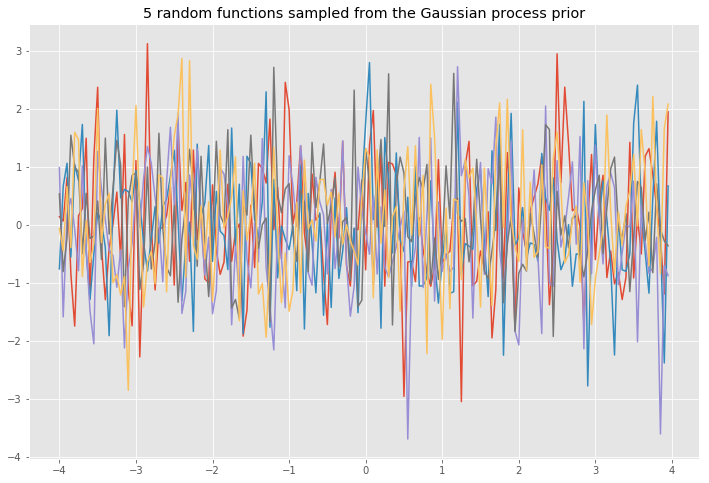

In [17]:
sample_GP_prior(5, covWN, [1.0])

Don't forget to play with the parameters of the covariance function to see how they affect the samples!

Lastly, don't forget that **sums and products of proper covariance function are also valid covariance functions**! This is extremely useful and powerful for modelling different aspects of the data.

Lets implement in Python a covariance function that is the sum of a Periodic and a White Noise, and then take some samples from it:

In [18]:
def covSUM_PER_WN(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covWN(x1, x2, cov_params[3:])

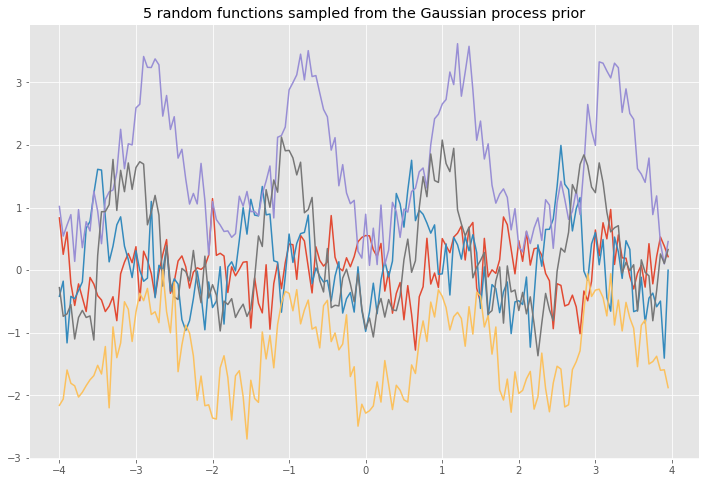

In [19]:
sample_GP_prior(5, covSUM_PER_WN, [1.0, 1.0, 2.0, 0.1])

Cool, right? Your GP prior now believes that this is how the data is like. In Part 2, we shall combine a GP prior with some observations (likelihood), and compute the posterior (exact Bayesian inference).

## Part 2: Inference and maximum marginal likelihood optimization

Let us start by generating some artificial data that follows more or less a sinusoid function (but with some missing values in the middle) plus Gaussian noise.

In [20]:
# generate some training data
X_train = np.hstack([-0.75 + np.random.rand(1,20), 0.75 + np.random.rand(1,20)]).T
y_train = np.sin(4.0*X_train) + 0.1*np.random.randn(len(X_train), 1)
N_train = len(y_train)

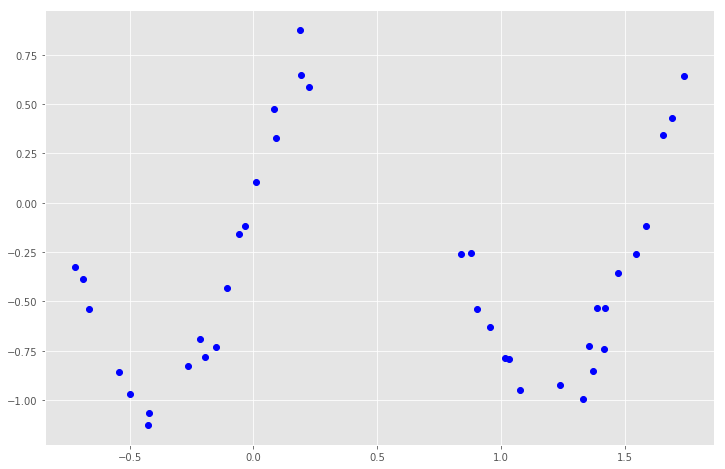

In [21]:
plt.plot(X_train, y_train, "bo")
plt.show()

We will now perform exact inference on the GP to compute the posterior:

\begin{align}
	p(\textbf{f}|\textbf{y},\textbf{X}) = \frac{p(\textbf{y}|\textbf{f}) \, p(\textbf{f})}{ p(\textbf{y}|\textbf{X}) } 
\end{align}

We assume a Gaussian likelihood of the form:

\begin{align}
	p(y_n|f_n) = \mathcal{N}(y_n|f_n,\sigma^2)
\end{align}

The **posterior distribution** therefore becomes:

\begin{align}
	p(\textbf{f}|\textbf{y},\textbf{X}) \propto \mathcal{N}(\textbf{y} | \textbf{f}, \sigma^2 \textbf{I}) \, \mathcal{N}(\textbf{f}|\textbf{0},\textbf{K}) 
\end{align}

Since both prior and likelihood are Gaussian, we can compute the exact posterior analytically using the stardard results shown in slides 4 and 5 of Lecture 10. 

Similarly, we can also determine the **marginal likelihood** of the data analytically (again using the stardard results shown in slides 4 and 5 of Lecture 10):

\begin{align}
	p(\textbf{y}|\textbf{X}) = \int \mathcal{N}(\textbf{y} | \textbf{f}, \sigma^2 \textbf{I}) \, \mathcal{N}(\textbf{f}|\textbf{0},\textbf{K}) \, d\textbf{f} = \mathcal{N}(\textbf{y}|\textbf{0},\sigma^2\textbf{I} + \textbf{K})
\end{align}

However, our main interest is to make predictions for new test points $\textbf{x}_*$ and that requires computing $p(\textbf{y}_*|\textbf{y},\textbf{x}_*,\textbf{X})$. This can be done by starting from the joint distribution $p(y_*,\textbf{y}|\textbf{x}_*,\textbf{X})$ given by

\begin{align}
p(y_*,\textbf{y}|\textbf{x}_*,\textbf{X}) = \mathcal{N}(y_*,\textbf{y}|\textbf{0}, \textbf{V}) \nonumber
\end{align}

with
\begin{align}
\textbf{V} = \left(\begin{array}{cc} \sigma^2\textbf{I} + \textbf{K} & \textbf{k}_* \\\textbf{k}_*^T & \sigma^2 + k_{**}\end{array}\right) \nonumber
\end{align}

where $\textbf{k}_* = k(\textbf{x},x_*)$ and $k_{**} = k(x_*,x_*)$.

By making use of the stardard results shown in slides 4 and 5 of Lecture 10, we can now compute the **conditional (predictive) distribution**:

\begin{align}
	p(y_*|\textbf{y},\textbf{x}_*,\textbf{X}) &= \mathcal{N}(y_*|\textbf{k}_*^T (\sigma^2\textbf{I} + \textbf{K})^{-1} \, \textbf{y}, \, k_{**} + \sigma^2 - \textbf{k}_*^T (\sigma^2\textbf{I} + \textbf{K})^{-1} \textbf{k}_*) \nonumber
\end{align}

Can you write a Python function that computes this predictive posterior distribution?

In [45]:
def compute_predictive_posterior(X_test, sigma, cov_params):
    N_test = len(X_test)

    predictions = np.zeros(N_test)
    variances = np.zeros(N_test)
    
    K = cov(X_train, X_train, covSE, cov_params)
    inverse = np.linalg.inv(K+sigma**2*np.eye(len(X_train)))
    
    
    for i in range(0,N_test):
        kstar = cov(X_train, X_test[i][:,np.newaxis], covSE, cov_params)
        kstarstar = cov(X_test[i][:,np.newaxis], X_test[i][:,np.newaxis], covSE, cov_params)
        #print((kstarstar + sigma**2 - np.dot(np.dot(kstar.T, inverse), kstar)).shape)
        predictions[i] = np.dot(np.dot(kstar.T, inverse), y_train)
        variances[i] = kstarstar + sigma**2 - np.dot(np.dot(kstar.T, inverse), kstar)
    # TODO: Compute prediction means and variances for all x_* in the test set.
    # Note that K (and K^{-1}) is the same for all x_*. You don't need to re-compute it every time (slow! O(N^3))
    
    print(X_test[i][:,np.newaxis].shape)
    print(X_test[i].shape)
    
    return predictions, variances

We can use this function to compute the predictive means and variances for a range of values, e.g. [-4,4]:

In [46]:
X_test = np.arange(-4,4,0.05)[:,np.newaxis]
cov_params = [0.5]
sigma = 0.1
predictions, variances = compute_predictive_posterior(X_test, sigma, cov_params)

(1, 1)
(1,)


And visualize it:

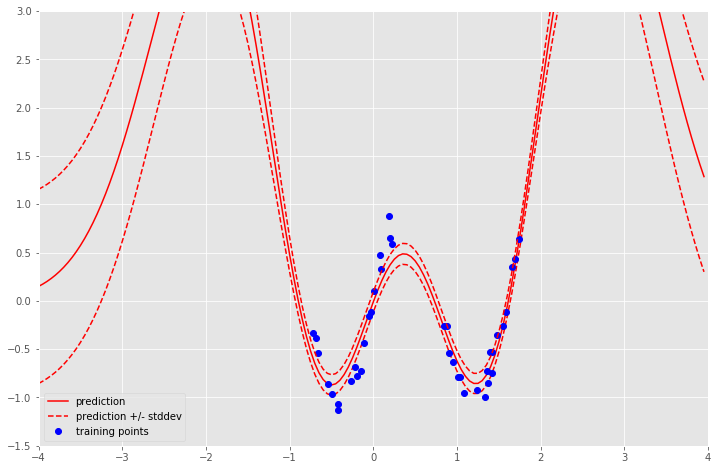

In [47]:
plt.plot(X_test, predictions, 'r-')
plt.plot(X_test, predictions - np.sqrt(variances), 'r--')
plt.plot(X_train, y_train, "bo")
plt.plot(X_test, predictions + np.sqrt(variances), 'r--')
plt.axis([-4,4,-1.5,3])
plt.legend(["prediction", "prediction +/- stddev", "training points"])
plt.show()

Notice how the uncertainty increases away from the observations (training points).

This is not a bad fit, but perhaps we can do better. Particularly, we selected an arbitrary value for the length-scale $l$ of the covariance function of the GP. Alternatively, we can try to **find an optimal value for the length-scale $l$** by maximing the marginal likelihood of the data:

\begin{align}
	\hat{l} = \arg\max_{l} \Big( \log \, \mathcal{N}(\textbf{y}|\textbf{0},\sigma^2\textbf{I} + \textbf{K}) \Big) 
\end{align}

Unfortunaly, we cannot solve this equation analytically. We must resort to **numerical optimization** methods. These methods require use to define an objective function and typically an function that computes the gradients of the objective function with respect to the variable that we are trying to optimize.

So, lets start by defining our objective function, which in this case is the log marginal likelihood:

\begin{align}
	\log \, \mathcal{N}(\textbf{y}|\textbf{0},\sigma^2\textbf{I} + \textbf{K}) = -\frac{N}{2} \log(2\pi) -\frac{1}{2} \log(\det(\sigma^2\textbf{I} + \textbf{K})) - \frac{1}{2} \textbf{y}^T (\sigma^2\textbf{I} + \textbf{K})^{-1} \textbf{y}
\end{align}

In [48]:
def log_marginal_loglikelihood(params):
    K_sigma = cov(X_train, X_train, covSE, params) + sigma**2 * np.eye(N_train)
    K_sigma_inv = np.linalg.inv(K_sigma)

    loglikelihood = -0.5*np.dot(np.dot(y_train.T, K_sigma_inv), y_train) - 0.5*np.log(np.linalg.det(K_sigma)) - 0.5*N_train*np.log(2*np.pi)
    print("loglikelihood: %.3f\t(params=%s)" % (loglikelihood[0,0], str(params)))
    
    return -loglikelihood[0]

In [49]:
# test objective function
log_marginal_loglikelihood([0.5])

loglikelihood: -104.000	(params=[0.5])


array([103.9999573])

Notice that the function returns "-loglikelihood", this is just because the numerical optimization methods that Scipy provides are for minimization. We there transform the maximization problem into a minimization one by reverting the signal of the objective function.

Ok, the next step is to take derivatives of the log marginal likelihood with respect to $l$ (a value that was used to compute $\textbf{C}$).

\begin{align}
\frac{\partial \log p(\textbf{y}|\textbf{X})}{\partial l} &=  - \frac{1}{2} \frac{\partial \log |\textbf{C}|}{\partial l} - \frac{1}{2} \textbf{y}^T \frac{\partial \textbf{C}^{-1}}{\partial l} \textbf{y}\\
&=  - \frac{1}{2} \mbox{Tr} \Bigg[\textbf{C}^{-1} \frac{\partial \textbf{C}}{\partial l}\Bigg] + \frac{1}{2} \textbf{y}^T \textbf{C}^{-1} \frac{\partial \textbf{C}}{\partial l} \textbf{C}^{-1} \textbf{y}
\end{align}

where, to simplify notation, we defined $\textbf{C} = \sigma^2\textbf{I} + \textbf{K}$ and $\mbox{Tr}(\textbf{A})$ denotes the trace of the matrix $\textbf{A}$.

In [50]:
def gradient(params):
    gradient = np.zeros(len(params))
    Wl = covSEiso_gradient(params)
    
    K_sigma = cov(X_train, X_train, covSE, params) + sigma**2 * np.eye(N_train)
    K_sigma_inv = np.linalg.inv(K_sigma)
    K_inv_Wl = np.dot(K_sigma_inv, Wl)
    
    gradient[0] = 0.5*np.dot(np.dot(np.dot(y_train.T, K_inv_Wl), K_sigma_inv), y_train) - 0.5*np.trace(K_inv_Wl)
    return -gradient

We still need to compute $\partial \textbf{C} \, / \, \partial l$. For that we just need the derivative of the covariance function with respect to the hyper-parameter $l$:

\begin{align}
\frac{\partial k(\textbf{x},\textbf{x}') }{\partial l} &= - \bigg( \sum_{d=1}^D (x_d - x'_d)^2 \bigg) \, \exp \bigg( - l \, \sum_{d=1}^D (x_d - x'_d)^2 \bigg)
\end{align}

And implementing in Python...

In [51]:
def covSEiso_gradient(params):
    W = np.zeros((N_train, N_train))
    for i in range(N_train):
        for j in range(N_train):
            W[i,j] = -np.sum((X_train[i,:] - X_train[j,:])**2) * np.exp(-params[0]*np.sum((X_train[i,:] - X_train[j,:])**2))
    return W

In [52]:
# test gradient function
gradient([2.0])

array([-1.73055944])

Ok, it is now time to run Scipy's optimizer. In this case we use a conjugate gradients method...

In [53]:
from scipy.optimize.optimize import fmin_cg

cov_params_init = np.array([0.5])
cov_params_opt = fmin_cg(log_marginal_loglikelihood, cov_params_init, fprime=gradient, maxiter=10)
#params = fmin_cg(marginal_loglikelihood, params, maxiter=10)

loglikelihood: -104.000	(params=[0.5])
loglikelihood: 14.773	(params=[1.51])
loglikelihood: 11.724	(params=[9.19463576])
loglikelihood: 15.888	(params=[3.93547001])
loglikelihood: 11.724	(params=[9.19463576])
loglikelihood: 14.723	(params=[5.16365286])
loglikelihood: 16.743	(params=[3.08021938])
loglikelihood: 17.028	(params=[2.65540575])
loglikelihood: 17.071	(params=[2.49145218])
loglikelihood: 17.073	(params=[2.45486971])
loglikelihood: 17.073	(params=[2.45084461])
loglikelihood: 17.073	(params=[2.45074418])
Optimization terminated successfully.
         Current function value: -17.072561
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 10


Lets now see how the predictive posterior looks like for the new (optimized) covariance function hyper-parameter $l$.

In [54]:
predictions, variances = compute_predictive_posterior(X_test, sigma, cov_params_opt)

(1, 1)
(1,)


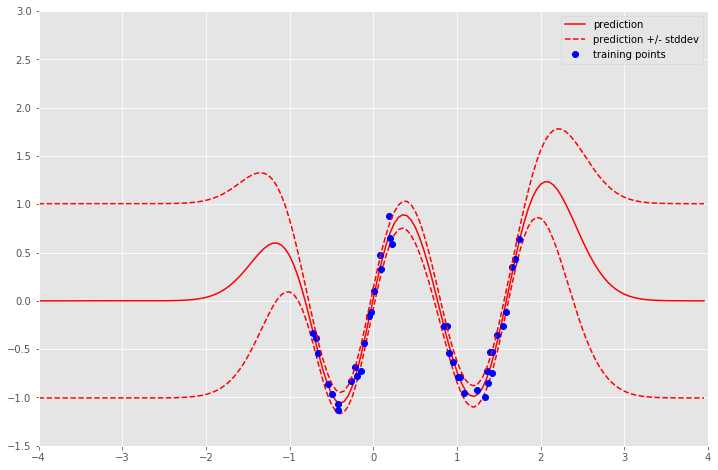

In [55]:
plt.plot(X_test, predictions, 'r-')
plt.plot(X_test, predictions - np.sqrt(variances), 'r--')
plt.plot(X_train, y_train, "bo")
plt.plot(X_test, predictions + np.sqrt(variances), 'r--')
plt.axis([-4,4,-1.5,3])
plt.legend(["prediction", "prediction +/- stddev", "training points"])
plt.show()

Much better, right? The hyper-parameter $l$ was optimized (numerically) to fit the data better. Well, at least acording to the marginal likelihood of the data... Also, be aware that the optimization problem is non-convex! Therefore, initialization can matter a lot!

If all this stuff above made sense to you (mathematical details aside), you now understand the core of Gaussian processes :-)

## Part 3: Gaussian processes in STAN

STAN implementation of the same Gaussian process in STAN (adapted from STAN's Manual):

In [26]:
import pystan
import pystan_utils

# adapted from STAN's manual
model_definition = """
data {
    int<lower=1> N;
    real x[N];
    vector[N] y;
}
transformed data {
    vector[N] mu = rep_vector(0, N);
}
parameters {
    real<lower=0> l;
} model {
    matrix[N, N] L_K;
    matrix[N, N] K = cov_exp_quad(x, 1.0, l);
    real sq_sigma = square(0.1);
    
    // diagonal elements
    for (n in 1:N)
        K[n, n] = K[n, n] + sq_sigma;
        
    L_K = cholesky_decompose(K);
    
    l ~ inv_gamma(5, 5);
    
    y ~ multi_normal_cholesky(mu, L_K);
}
"""

# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a6bd0952397af88dc5b36610e4bf213 NOW.


In [27]:
# prepare data for Stan model
data = {'N': len(y_train), 'x': X_train[:,0], 'y': y_train[:,0]}

# run inference using MCMC
fit = sm.sampling(data=data, iter=2000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

/Users/fmpr/anaconda/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_2a6bd0952397af88dc5b36610e4bf213.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
l      0.49  1.5e-3   0.05   0.38   0.45   0.49   0.52   0.58   1234    1.0
lp__  39.68    0.03   0.78  37.55  39.54  39.97  40.13  40.18    926   1.01

Samples were drawn using NUTS at Wed May  2 16:34:19 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Compare the infered value of $l$ with the value obtained before by optimizing the marginal likelihood of the data:

In [28]:
samples = fit.extract("l")
l = 1/(2*(np.mean(samples["l"])**2)) 
print("l=", l)

l= 2.102797401850464


Full GP implementation in STAN for making predictions (taken from STAN's Manual):

In [29]:
# adapted from STAN's manual
model_definition = """ 
data {
    int<lower=1> N1;
    real x1[N1];
    vector[N1] y1;
    int<lower=1> N2;
    real x2[N2];
}
transformed data {
    real delta = 1e-9;
    int<lower=1> N = N1 + N2;
    real x[N];
    for (n1 in 1:N1) x[n1] = x1[n1];
    for (n2 in 1:N2) x[N1 + n2] = x2[n2];
}
parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    real<lower=0> sigma;
    vector[N] eta;
}
transformed parameters {
    vector[N] f;
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        
        // diagonal elements
        for (n in 1:N)
            K[n, n] = K[n, n] + delta;
            
        L_K = cholesky_decompose(K);
        f = L_K * eta; 
    }
} model {
    rho ~ inv_gamma(5, 5);
    alpha ~ normal(0, 1);
    sigma ~ normal(0, 1);
    eta ~ normal(0, 1);
    y1 ~ normal(f[1:N1], sigma);
}
generated quantities {
    vector[N2] y2;
    for (n2 in 1:N2)
        y2[n2] = normal_rng(f[N1 + n2], sigma);
}
"""

# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23f38c22e028fd461d8f369aedfb9f81 NOW.


In [30]:
# prepare data for Stan model
data = {'N1': len(y_train), 'x1': X_train[:,0], 'y1': y_train[:,0], "N2": len(X_test), "x2": X_test[:,0]}

# ADVI works well for this model and it is much faster!
fit = sm.vb(data=data, iter=5000, algorithm="meanfield", elbo_samples=100, grad_samples=1, seed=42, verbose=True)

/Users/fmpr/anaconda/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [31]:
y2 = pystan_utils.vb_extract_variable(fit, "y2", var_type="vector")

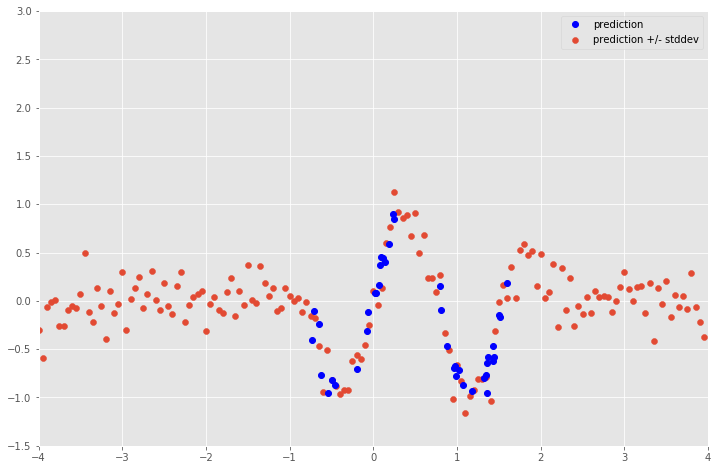

In [32]:
plt.scatter(X_test, y2)
plt.plot(X_train, y_train, "bo")
plt.axis([-4,4,-1.5,3])
plt.legend(["prediction", "prediction +/- stddev", "training points"])
plt.show()

Remember: STAN returns a set of samples from the posterior. The red dots correspond to the mean of those samples for each input point.